In [38]:
pip install torchvision albumentations

Note: you may need to restart the kernel to use updated packages.


Image 15 - Box 0: Class 0, X_center 0.678330013168539, Y_center 0.33702736206730344, Width 0.18747286924375495, Height 0.18092825477146462


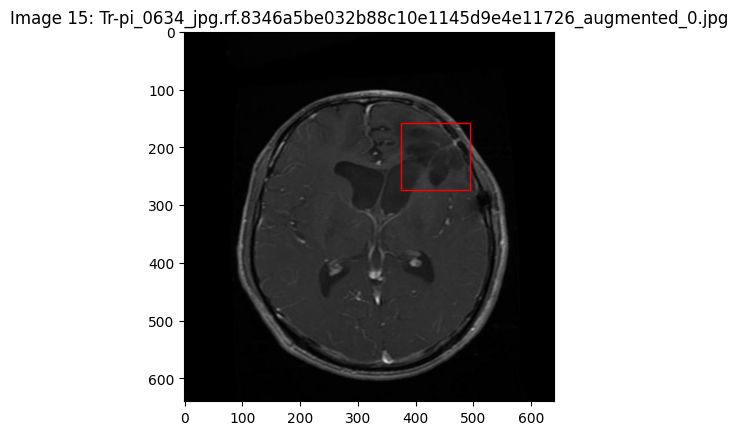

Image 808 - Box 0: Class 2, X_center 0.5171875, Y_center 0.53203125, Width 0.6031250000000001, Height 0.7328125000000001


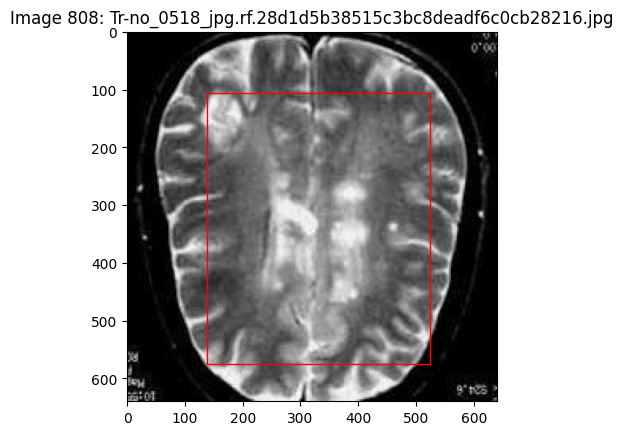

Image 855 - Box 0: Class 0, X_center 0.390625, Y_center 0.36328125, Width 0.109375, Height 0.22343749999999996


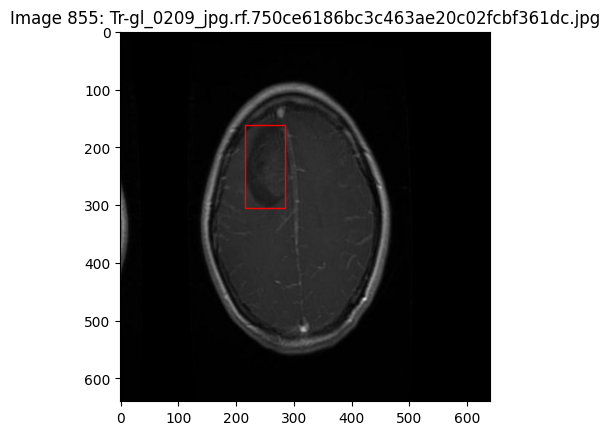

Image 195 - Box 0: Class 1, X_center 0.7625, Y_center 0.7734375, Width 0.475, Height 0.453125
Image 195 - Box 1: Class 1, X_center 0.36953125, Y_center 0.2203125, Width 0.42656249999999996, Height 0.440625


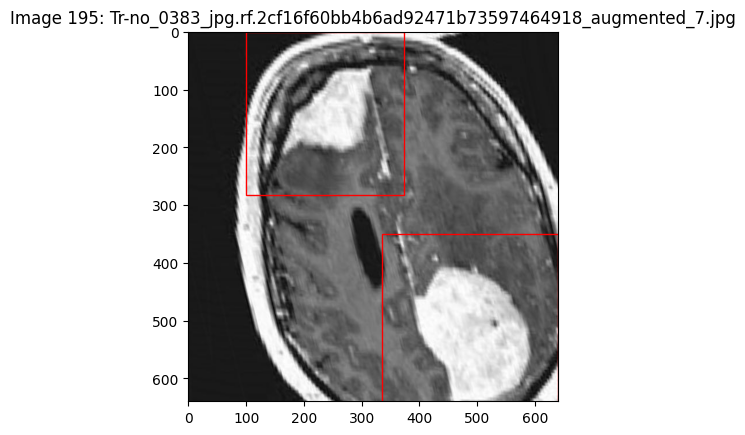

Image 527 - Box 0: Class 1, X_center 0.3920793507555881, Y_center 0.5126883724247684, Width 0.1755219254034988, Height 0.16395929624570438


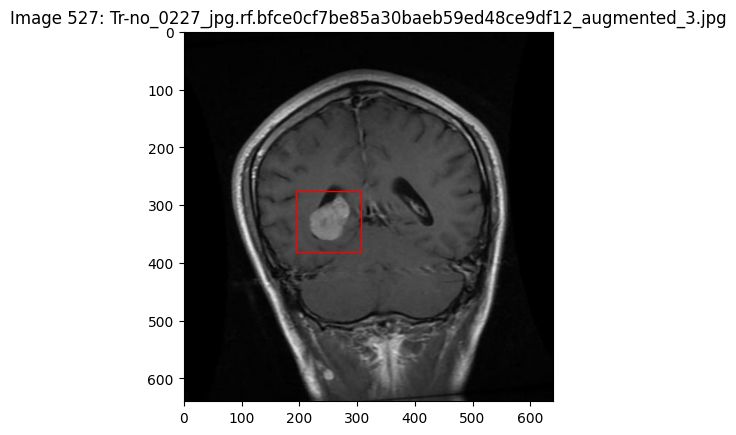

Image 311 - Box 0: Class 2, X_center 0.47421875, Y_center 0.56171875, Width 0.5125, Height 0.6625000000000001


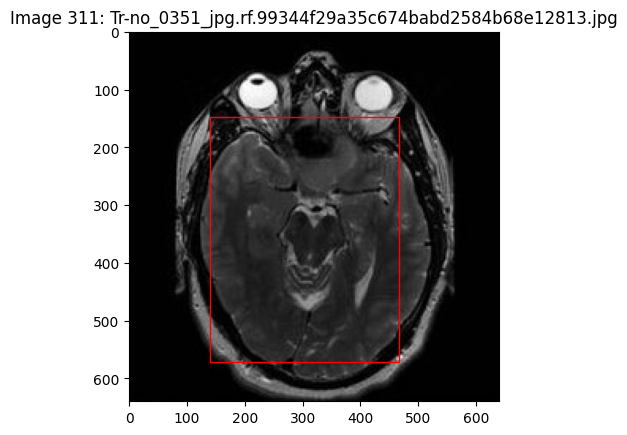

Image 486 - Box 0: Class 1, X_center 0.3694889287382206, Y_center 0.6701940239430141, Width 0.13682519733295972, Height 0.16421192293317266


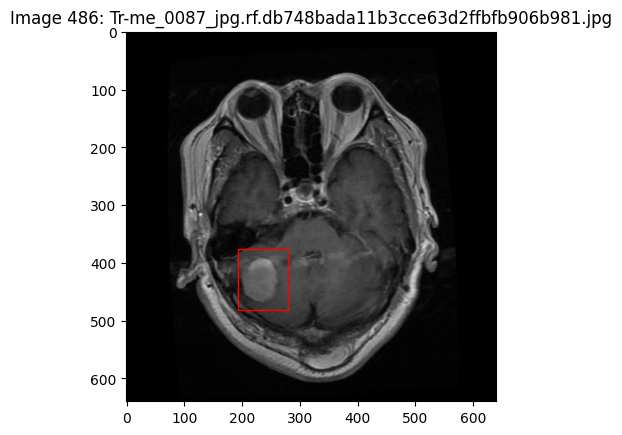

Image 850 - Box 0: Class 1, X_center 0.4921875, Y_center 0.58359375, Width 0.15625, Height 0.13593750000000004


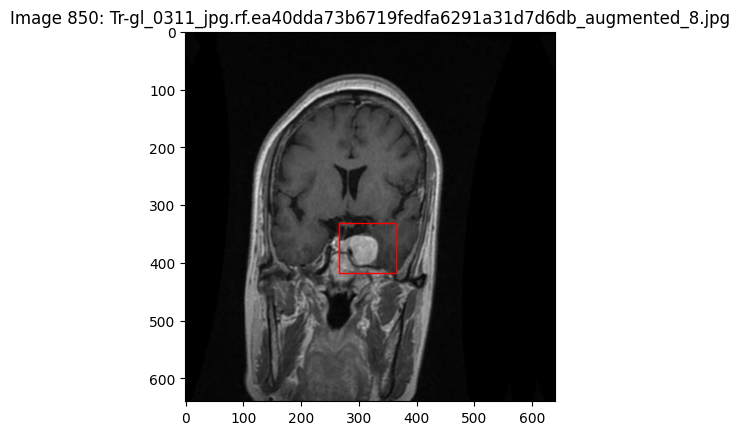

Image 969 - Box 0: Class 0, X_center 0.5925520244394844, Y_center 0.4618012148594282, Width 0.1684648915714807, Height 0.1427839201865767


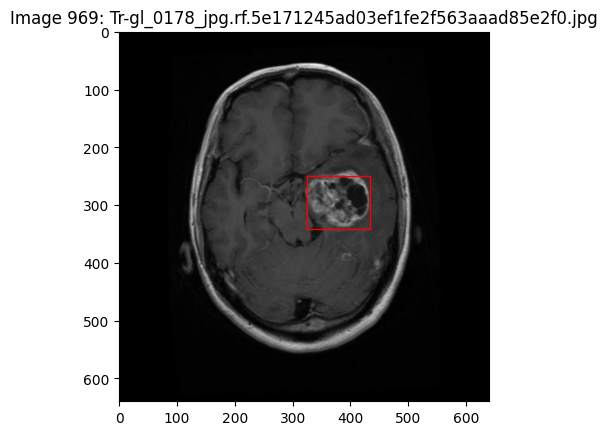

Image 30 - Box 0: Class 3, X_center 0.543987650387902, Y_center 0.515613655316349, Width 0.14939226568656128, Height 0.13393955795622298


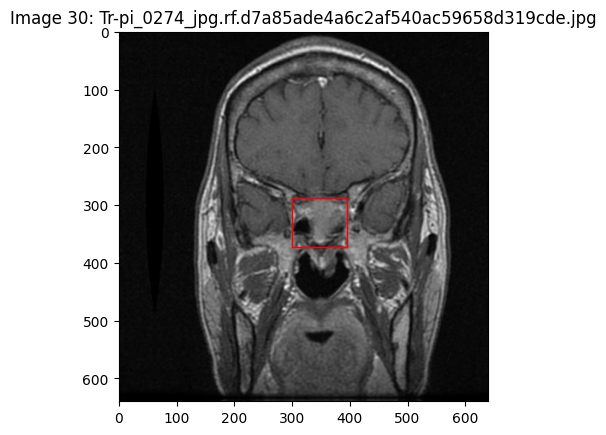

In [39]:
import os
import cv2
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import save_image
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Custom dataset class
class CustomDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.images = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith(".jpg")]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image_path = self.images[idx]
        image_name = os.path.basename(image_path)
        label_path = os.path.join(self.label_dir, image_name.replace('.jpg', '.txt'))

        # Load image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Load labels
        bboxes = []
        if os.path.exists(label_path):
            with open(label_path, 'r') as file:
                for line in file:
                    class_id, x_center, y_center, width, height = map(float, line.split())
                    bboxes.append([x_center - width / 2, y_center - height / 2, x_center + width / 2, y_center + height / 2, class_id])

        if self.transform:
            transformed = self.transform(image=image, bboxes=bboxes, class_labels=[bbox[4] for bbox in bboxes])
            image = transformed['image']
            bboxes = transformed['bboxes']

        return image, bboxes

# Collation function to handle batching
def custom_collate_fn(batch):
    images = [item[0] for item in batch]
    bboxes = [item[1] for item in batch]
    images = torch.stack(images, dim=0)
    return images, bboxes

# Transformation
transform = A.Compose([
    A.Rotate(limit=(-10, 10), p=0.5),
    A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=0, p=0.5),
    A.HorizontalFlip(p=0.5),
    A.ElasticTransform(alpha=1, sigma=50, alpha_affine=50, p=0.5),
    A.Resize(640, 640),  
    ToTensorV2()
], bbox_params=A.BboxParams(format='albumentations', label_fields=['class_labels']))

# Setup dataset and dataloader
image_dir = 'MRI_BT5153/valid/images'
label_dir = 'MRI_BT5153/valid/labels'
dataset = CustomDataset(image_dir, label_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True, collate_fn=custom_collate_fn)

# Directory setup for saving augmented data
save_image_dir = 'MRI_BT5153/train/augmented_images'
save_label_dir = 'MRI_BT5153/train/augmented_labels'
os.makedirs(save_image_dir, exist_ok=True)
os.makedirs(save_label_dir, exist_ok=True)

# Saving images and labels
for i, (images, bboxes) in enumerate(dataloader):
    for j, (image, bbox) in enumerate(zip(images, bboxes)):
        if image.max() > 1:
            image = image / 255.0

        original_name = os.path.splitext(os.path.basename(dataset.images[i * 10 + j]))[0]
        img_filename = f'{original_name}_augmented_{j}.jpg'
        save_path = os.path.join(save_image_dir, img_filename)
        save_image(image, save_path)

        # Save labels
        label_filename = f'{original_name}_augmented_{j}.txt'
        label_path = os.path.join(save_label_dir, label_filename)
        with open(label_path, 'w') as f:
            for box in bbox:
                x_center = (box[0] + box[2]) / 2 
                y_center = (box[1] + box[3]) / 2 
                width = (box[2] - box[0]) 
                height = (box[3] - box[1])
                class_id = int(box[4])  # Convert class_id to integer
                x_center = min(max(x_center, 0), 1)
                y_center = min(max(y_center, 0), 1)
                width = min(max(width, 0), 1)
                height = min(max(height, 0), 1)
                f.write(f'{class_id} {x_center} {y_center} {width} {height}\n')

# Visualization function
def visualize_augmentation(image, bboxes, image_name, idx, image_size=640):
    image_np = image.cpu().numpy().transpose(1, 2, 0)
    fig, ax = plt.subplots(1)
    ax.imshow(image_np)
    ax.set_title(f'Image {idx}: {image_name}')

    # Draw bounding boxes 
    for i, box in enumerate(bboxes):
        x_center = (box[0] + box[2]) / 2 
        y_center = (box[1] + box[3]) / 2
        width = (box[2] - box[0]) 
        height = (box[3] - box[1]) 
        class_id = int(box[4])

        # Draw rectangle on image
        rect = patches.Rectangle(
            (box[0] * image_size, box[1] * image_size),
            width * image_size, height * image_size,
            linewidth=1, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)

        print(f"Image {idx} - Box {i}: Class {class_id}, X_center {x_center}, Y_center {y_center}, Width {width}, Height {height}")

    plt.show()

# Define a minimum size for bounding boxes 
min_bbox_size = 0.01 * 640  # 1% of the image size

random_indices = random.sample(range(len(dataset)), 10)
for idx in random_indices:
    image, bboxes = dataset[idx]
    image_name = os.path.basename(dataset.images[idx])
    visualize_augmentation(image, bboxes, image_name, idx)